In [1]:
import xupy as xp
import matplotlib.pyplot as plt

from ekarus.e2e.single_stage_ao_class import SingleStageAO
from ekarus.e2e.utils.image_utils import remap_on_new_mask
from ekarus.analytical.zernike_generator import ZernikeGenerator

import ekarus.e2e.utils.my_fits_package as my_fits

from scipy.interpolate import Rbf


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
def create_field_from_zernike_coefficients(mask, noll_ids, amplitudes):
    """
    Create an electric field input corresponding to a Zernike aberration.
    
    :param mask: CircularMask object defining the pupil
    :param noll_ids: tuple of Zernike noll number
    :param amplitudes: Amplitude or tuple of amplitudes
                       of the Zernike aberration in radians
    
    :return: input electric field as a numpy complex array
    """
    phase_mask = project_zernike_on_mask(mask, noll_ids, amplitudes)
    return (1-mask) * xp.exp(1j * phase_mask)


def project_zernike_on_mask(mask, noll_ids, amplitudes):
    """
    Create a linear combination of Zernikes on a mask.
    
    :param mask: CircularMask object defining the pupil
    :param noll_ids: tuple of Zernike noll number
    :param amplitudes: Amplitude or tuple of amplitudes
                       of the Zernike aberration in radians
    
    :return: zernike combination
    """
    mask_size = max(mask.shape)
    zg = ZernikeGenerator(xp.asnumpy(mask),mask_size//2)

    if isinstance(noll_ids,int):
        amp = amplitudes
        noll = noll_ids
        zern = amp * xp.asarray(zg.getZernike(int(noll)))
    else:
        amplitudes *= xp.ones_like(noll_ids)
        zern = xp.zeros(mask.shape)
        for amp,noll in zip(amplitudes, noll_ids):
            zern += amp * xp.asarray(zg.getZernike(int(noll)))

    return zern

# def get_tichonov_rec(KL, m2c, visible_ids, gamma:float=1e-4, modal:bool=False):
#     IM = KL.T @ xp.linalg.pinv(m2c) #m2c @ xp.linalg.pinv(KL.T)
#     IMm = IM[visible_ids,:]
#     U,S,V = xp.linalg.svd(IMm,full_matrices=False)
#     Sinv = 1/S
#     LAMBDA = S**2/(gamma+S**2) * Sinv
#     LAMBDA[S/max(S)>gamma] = Sinv[S/max(S)>gamma]
#     newRec = (V.T * LAMBDA) @ U.T
#     if modal:
#         newRec = xp.linalg.pinv(m2c) @ newRec
#     return newRec

def get_tichonov_rec(IF, gamma:float=1e-4):
    U,S,V = xp.linalg.svd(IF,full_matrices=False)
    Sinv = 1/S
    LAMBDA = S**2/(gamma+S**2) * Sinv
    LAMBDA[S/max(S)>gamma] = Sinv[S/max(S)>gamma]
    newRec = (V.T * LAMBDA) @ U.T
    return newRec

In [14]:
def specula_slaving(cmask,coordinates,n_act:int=32,dim:int=128,slaving_thr:float=0.2):
    idx = xp.where(1-cmask)
    step = dim/n_act

    # x, y = xp.meshgrid(xp.linspace(0, dim, n_act), xp.linspace(0, dim, n_act))
    # x, y = x.ravel(), y.ravel()
    # x_c, y_c = dim / 2, dim / 2 # center
    # rho = xp.sqrt((x-x_c)**2+(y-y_c)**2)
    # rho_max = (dim*(9/8-n_act/(24*16)))/2 # slightly larger than dim, depends on n_act
    # x = x[rho<=rho_max]
    # y = y[rho<=rho_max]
    # n_act_tot = int(xp.size(x))
    # coordinates = xp.vstack((x,y))
    x,y = coordinates
    n_act_tot = xp.shape(coordinates)[1]
    grid_x, grid_y = xp.meshgrid(xp.arange(dim), xp.arange(dim))

    ifs_cube = xp.zeros((n_act_tot, dim, dim), dtype=xp.float)

    # Minimum distance between points
    min_distance_norm = 9*step

    for i in range(n_act_tot):
        z = xp.zeros(n_act_tot, dtype=xp.float)
        z[i] = 1.0  # Set the central actuator
        if min_distance_norm >= dim/2:
            x_close, y_close, z_close = x, y, z
            idx_far_grid = None
        else:
            distance = xp.sqrt((x - x[i]) ** 2 + (y - y[i]) ** 2)
            idx_close = xp.where(distance <= min_distance_norm)[0]
            x_close, y_close, z_close = x[idx_close], y[idx_close], z[idx_close]           
            # Compute the distance grid
            distance_grid = xp.sqrt((grid_x.ravel() - x[i]) ** 2 + (grid_y.ravel() - y[i]) ** 2)
            idx_far_grid = xp.where(distance_grid > 0.8*min_distance_norm)[0]
        # Convert to NumPy arrays for Rbf interpolation (required)
        x_close_np = xp.asnumpy(x_close)
        y_close_np = xp.asnumpy(y_close)
        z_close_np = xp.asnumpy(z_close)
        grid_x_np = xp.asnumpy(grid_x)
        grid_y_np = xp.asnumpy(grid_y)
        # Interpolation using Thin Plate Splines (using NumPy arrays)
        rbf = Rbf(x_close_np, y_close_np, z_close_np, function='thin_plate')
        # Perform interpolation
        z_interp_np = rbf(grid_x_np, grid_y_np)
        # Convert back to xp array
        z_interp = xp.asarray(z_interp_np)
        if idx_far_grid is not None:
            z_interp.ravel()[idx_far_grid] = 0
        ifs_cube[i, :, :] = z_interp
    
    max_vals = xp.max(ifs_cube[:, idx[0], idx[1]], axis=1)
    max_vals_all = xp.max(ifs_cube, axis=(1, 2))
    idx_master = xp.where(max_vals >= slaving_thr * max_vals_all)[0]
    idx_slave = xp.where(max_vals < slaving_thr * max_vals_all)[0]

    print(f"Actuators: {n_act_tot}")
    print(f"Master actuators: {len(idx_master)}")
    print(f"Actuators to be slaved: {len(idx_slave)}")

    plt.figure()
    plt.imshow(xp.asnumpy(cmask),origin='lower',cmap='grey')
    plt.scatter(xp.asnumpy(x),xp.asnumpy(y),c='green',label='masters')
    plt.scatter(xp.asnumpy(x[idx_slave]),xp.asnumpy(y[idx_slave]),c='red',label='slaves')
    plt.legend()
    plt.grid()

    slaveMat1 = xp.zeros((n_act_tot, n_act_tot), dtype=xp.float)

    for i in range(n_act_tot):
        if i in idx_master:
            distance = xp.sqrt((coordinates[0] - coordinates[0][i])**2 + 
                            (coordinates[1] - coordinates[1][i])**2)

            idx_close_master1 = xp.where(distance <= 1.1 * step)[0]
            idx_close_master1 = xp.intersect1d(idx_close_master1, idx_slave)

            if len(idx_close_master1) > 0:
                for j in idx_close_master1:
                    slaveMat1[i, j] = 1.0

    for j in range(n_act_tot):
        slaveMat1[:, j] *= 1.0 / max(1.0, xp.sum(slaveMat1[:, j]))

    for i in range(n_act_tot):
        if xp.sum(slaveMat1[i, :]) > 0:
            idx_temp = xp.where(slaveMat1[i, :] > 0)[0]
            for j in idx_temp:
                ifs_cube[i] += slaveMat1[i, j] * ifs_cube[j]

    ifs_cube = ifs_cube[idx_master]
    n_act_tot = len(idx_master)

    ifs_2d = xp.array([ifs_cube[i][idx] for i in range(n_act_tot)], dtype=xp.float)

    return ifs_2d.T

In [4]:
ssao = SingleStageAO(tn='master_single_stage')
ssao.initialize_turbulence('ekarus_5cm')
KL, m2c = ssao.define_KL_modes(ssao.dm, zern_modes=2)

Initializing devices ...
Modulating 3 [lambda/D] with 20 modulation steps
Fried parameter is: 5.0 [cm] (seeing = 2.02")


Initializing devices ...
Modulating 3 [lambda/D] with 20 modulation steps
Unobscured actuators: 752/820


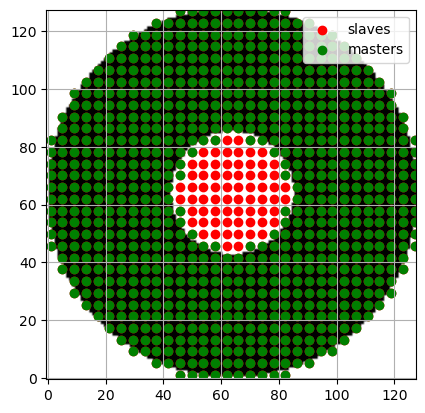

In [5]:
slav_ssao = SingleStageAO(tn='slaving_single_stage')
sKL, sm2c = slav_ssao.define_KL_modes(slav_ssao.dm, zern_modes=2)

Actuators: 820
Master actuators: 752
Actuators to be slaved: 68


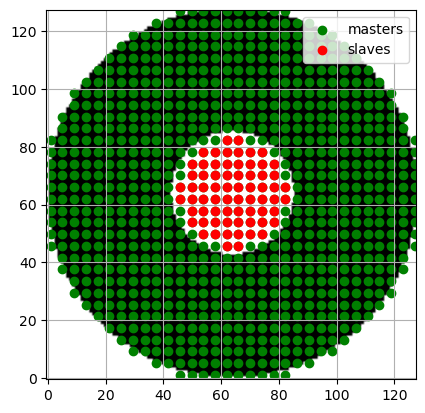

In [16]:
import os.path as op
filename = op.join(ssao.savecalibpath,'specula_iffs.fits')

try:
    specula_IFFs = my_fits.read_fits(filename)
except FileNotFoundError:
    specula_IFFs = specula_slaving(slav_ssao.cmask, ssao.dm.act_coords.copy(), slaving_thr=0.3)
    my_fits.save_fits(filename, specula_IFFs)

In [17]:
print(ssao.dm.IFF.shape, specula_IFFs.shape, xp.sum(1-slav_ssao.cmask), slav_ssao.dm.slaving.shape)

(12849, 820) (11416, 752) 11416 (820, 752)


In [ ]:
fa_IFFs = ssao.dm.IFF
visible_IFFs = ssao.dm.IFF[slav_ssao.dm.visible_pix_ids,:]
crop_IFFs = visible_IFFs[:,slav_ssao.dm.master_ids]

fa_Rec = xp.linalg.pinv(fa_IFFs)
crop_Rec = xp.linalg.pinv(crop_IFFs)
visible_Rec = xp.linalg.pinv(visible_IFFs)
specula_Rec = xp.linalg.pinv(specula_IFFs)
ticho_Rec = get_tichonov_rec(visible_IFFs, gamma=4e-3)

def get_rms_res_and_cmd(phase, IF, Rec, slaving=None, remap:bool=False):
    cmd = Rec @ phase
    if slaving is not None:
        cmd = slaving @ cmd
    rec_phase = IF @ cmd
    res_phase = phase - rec_phase
    if remap is True:
        res_phase = remap_on_new_mask(phase, ssao.cmask, slav_ssao.cmask)
    phi_rms = xp.sqrt(xp.sum(res_phase**2))/len(res_phase)
    cmd_rms = xp.sqrt(xp.sum(cmd**2))/len(abs(cmd)>0)
    max_cmd = xp.max(abs(cmd))
    return phi_rms, cmd_rms, max_cmd

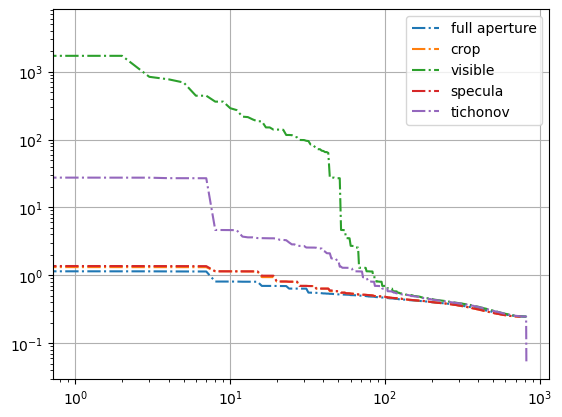

In [21]:
_,fa_D,_ = xp.linalg.svd(fa_Rec,full_matrices=False)
_,crop_D,_ = xp.linalg.svd(crop_Rec,full_matrices=False)
_,vis_D,_ = xp.linalg.svd(visible_Rec,full_matrices=False)
_,spe_D,_ = xp.linalg.svd(specula_Rec,full_matrices=False)
_,ticho_D,_ = xp.linalg.svd(ticho_Rec,full_matrices=False)

plt.figure()
plt.plot(xp.asnumpy(fa_D),'-.',label='full aperture')
plt.plot(xp.asnumpy(crop_D),'-.',label='crop')
plt.plot(xp.asnumpy(vis_D),'-.',label='visible')
plt.plot(xp.asnumpy(spe_D),'-.',label='specula')
plt.plot(xp.asnumpy(ticho_D),'-.',label='tichonov')
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')

In [18]:
N = 2000

phase_rms = xp.zeros(N)

fa_rms = xp.zeros(N) # full aperture
crop_rms = xp.zeros(N) # cropping IFFs
mean_rms = xp.zeros(N) # mean slaving
ticho_rms = xp.zeros(N) # tichonov regularization
specula_rms = xp.zeros(N) # adding slave IFFs to masters'

fa_cmd_rms = xp.zeros(N) # full aperture
crop_cmd_rms = xp.zeros(N) # cropping IFFs
mean_cmd_rms = xp.zeros(N) # mean slaving
ticho_cmd_rms = xp.zeros(N) # tichonov regularization
specula_cmd_rms = xp.zeros(N) # adding slave IFFs to masters'

fa_max_cmd = xp.zeros(N) # full aperture
crop_max_cmd = xp.zeros(N) # cropping IFFs
mean_max_cmd = xp.zeros(N) # mean slaving
ticho_max_cmd = xp.zeros(N) # tichonov regularization
specula_max_cmd = xp.zeros(N) # adding slave IFFs to masters'

for jj in range(N):
    atmo_phase = ssao.get_phasescreen_at_time(jj*ssao.dt)
    fa_phase = atmo_phase[~ssao.cmask]
    phase = atmo_phase[~slav_ssao.cmask]

    fa_phase -= xp.mean(fa_phase)
    phase -= xp.mean(phase)

    phase_rms[jj] = xp.sqrt(xp.sum(phase**2))/len(phase)

    # Full aperture
    fa_rms[jj], fa_cmd_rms[jj], fa_max_cmd[jj] = get_rms_res_and_cmd(fa_phase, fa_IFFs, fa_Rec)

    # Crop
    crop_rms[jj], crop_cmd_rms[jj], crop_max_cmd[jj] = get_rms_res_and_cmd(phase, crop_IFFs, crop_Rec)

    # mean
    mean_rms[jj], mean_cmd_rms[jj], mean_max_cmd[jj] = get_rms_res_and_cmd(phase, visible_IFFs, crop_Rec, slav_ssao.dm.slaving)

    # specula
    specula_rms[jj], specula_cmd_rms[jj], specula_max_cmd[jj] = get_rms_res_and_cmd(phase, specula_IFFs, specula_Rec)

    # tichonov
    ticho_rms[jj], ticho_cmd_rms[jj], ticho_max_cmd[jj] = get_rms_res_and_cmd(phase, visible_IFFs, ticho_Rec)


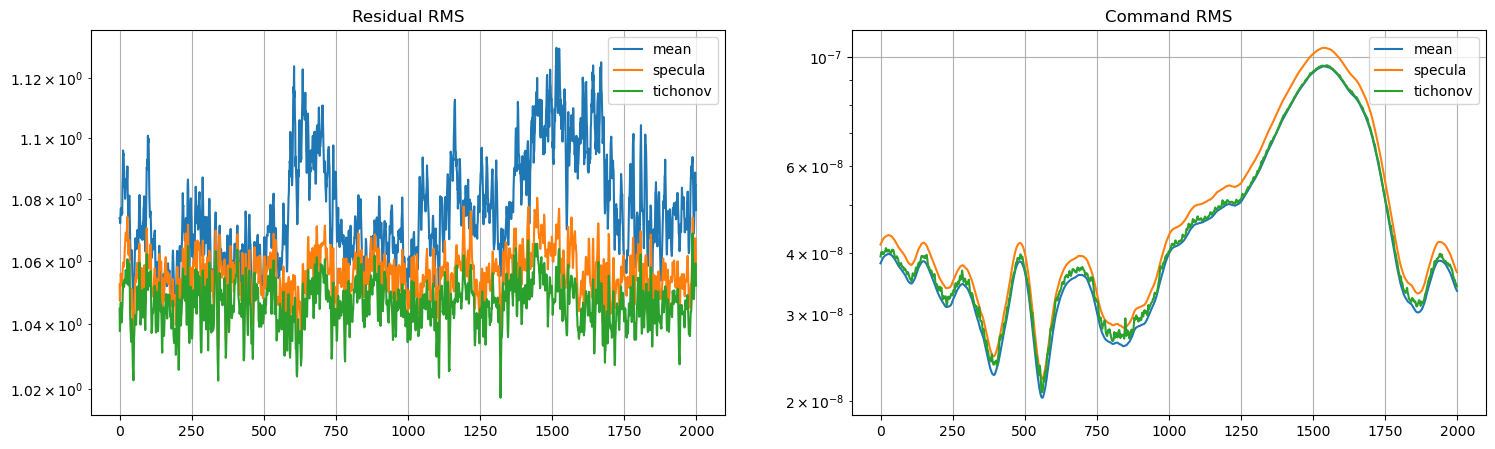

In [25]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(xp.asnumpy(mean_rms/fa_rms),label='mean')
plt.plot(xp.asnumpy(specula_rms/fa_rms),label='specula')
plt.plot(xp.asnumpy(ticho_rms/fa_rms),label='tichonov')
# plt.plot(xp.asnumpy(phase_rms),label='atmo')
plt.legend()
plt.title('Residual RMS')
plt.yscale('log')
plt.grid()
plt.subplot(1,2,2)
plt.plot(xp.asnumpy(mean_cmd_rms),label='mean')
plt.plot(xp.asnumpy(specula_cmd_rms),label='specula')
plt.plot(xp.asnumpy(ticho_cmd_rms),label='tichonov')
# plt.plot(xp.asnumpy(phase_rms),label='atmo')
plt.legend()
plt.title('Command RMS')
plt.yscale('log')
plt.grid()
# plt.subplot(2,2,3)
# plt.plot(xp.asnumpy(mean_rms/crop_rms),label='mean')
# plt.plot(xp.asnumpy(specula_rms/crop_rms),label='specula')
# plt.plot(xp.asnumpy(ticho_rms/crop_rms),label='tichonov')
# plt.legend()
# plt.title('Residual RMS')
# plt.yscale('log')
# plt.grid()
# plt.subplot(2,2,4)
# plt.plot(xp.asnumpy(mean_cmd_rms),label='mean')
# plt.plot(xp.asnumpy(specula_cmd_rms),label='specula')
# plt.plot(xp.asnumpy(ticho_cmd_rms),label='tichonov')
# plt.legend()
# plt.title('Command RMS')
# plt.yscale('log')
# plt.grid()

In [10]:
# # modal_amps = xp.random.randn(sdm.Nacts)
# # modal_scramble = IF @ modal_amps
# # mode_phase = reshape_on_mask(modal_scramble, ssao.cmask)

# zern_ids = xp.arange(2,28,dtype=int)
# zern_amps = xp.random.randn(len(zern_ids))*1e-8
# zern_order = xp.maximum(1,xp.round(xp.sqrt(zern_ids)))
# mode_phase = project_zernike_on_mask(ssao.cmask, zern_ids, zern_amps)

# # cmd_scramble = xp.zeros(sdm.Nacts)
# # cmd_scramble[sdm.master_ids] = xp.random.randn(len(sdm.master_ids))*1e-8
# # dm_shape = sdm.IFF @ cmd_scramble
# # mode_phase = reshape_on_mask(dm_shape, ssao.cmask)


# modal_scramble = mode_phase[~ssao.cmask]

# Rec = xp.linalg.pinv(IF)
# IFv = IF[sdm.visible_pix_ids,:]
# sRec = xp.linalg.pinv(IFv[:,master_ids])


# rec_cmd = Rec @ modal_scramble
# rec_shape = IF @ rec_cmd
# rec_phase = reshape_on_mask(rec_shape, ssao.cmask)

# slav_rec_cmd = sRec @ modal_scramble[sdm.visible_pix_ids]
# rec_shape = IF[:,master_ids] @ slav_rec_cmd
# srec_phase = reshape_on_mask(rec_shape, ssao.cmask)

# filt_rec_cmd = filtRec @ modal_scramble[sdm.visible_pix_ids]
# rec_shape = IF @ filt_rec_cmd
# frec_phase = reshape_on_mask(rec_shape, ssao.cmask)

# # newRec = get_lsq_rec(KL,m2c,sdm.visible_pix_ids,1e-3)
# newRec = get_tichonov_rec(KL,m2c,sdm.visible_pix_ids,4e-4)

# # rec_modes = newRec @ modal_scramble[sdm.visible_pix_ids]
# # rec_cmd = m2c @ rec_modes
# rec_cmd = newRec @ modal_scramble[sdm.visible_pix_ids]
# rec_shape = IF @ rec_cmd
# frec_phase = reshape_on_mask(rec_shape, ssao.cmask)

# # newRec = m2c @ xp.linalg.pinv(KL.T)
# # newIM = xp.linalg.pinv(newRec)
# # rec_shape = newIM @ modal_amps
# # # rec_cmd = newRec @ modal_scramble
# # # rec_shape = IF @ rec_cmd
# # frec_phase = reshape_on_mask(rec_shape, ssao.cmask)

# plt.figure(figsize=(20,8))
# plt.subplot(2,4,1)
# plt.imshow(masked_array(xp.asnumpy(mode_phase),mask=xp.asnumpy(ssao.cmask)),origin='lower')
# plt.colorbar()
# plt.axis('off')
# plt.title('Modal scramble')
# plt.subplot(2,4,2)
# plt.imshow(masked_array(xp.asnumpy(rec_phase),mask=xp.asnumpy(ssao.cmask)),origin='lower')
# plt.colorbar()
# plt.axis('off')
# plt.title('Reconstructed (no slaving)')
# plt.subplot(2,4,3)
# plt.imshow(masked_array(xp.asnumpy(srec_phase),mask=xp.asnumpy(ssao.cmask)),origin='lower')
# plt.colorbar()
# plt.axis('off')
# plt.title('Reconstructed (slaving)')
# plt.subplot(2,4,6)
# plt.imshow(masked_array(xp.asnumpy(mode_phase-rec_phase),mask=xp.asnumpy(slav_ssao.cmask)),origin='lower')
# plt.colorbar()
# plt.axis('off')
# plt.title('Difference (no slaving)')
# plt.subplot(2,4,7)
# plt.imshow(masked_array(xp.asnumpy(mode_phase-srec_phase),mask=xp.asnumpy(slav_ssao.cmask)),origin='lower')
# plt.colorbar()
# plt.axis('off')
# plt.title('Difference (slaving)')
# plt.subplot(2,4,4)
# plt.imshow(masked_array(xp.asnumpy(frec_phase),mask=xp.asnumpy(ssao.cmask)),origin='lower')
# plt.colorbar()
# plt.axis('off')
# plt.title('Reconstructed (slaving filtered)')
# plt.subplot(2,4,8)
# plt.imshow(masked_array(xp.asnumpy(mode_phase-frec_phase),mask=xp.asnumpy(slav_ssao.cmask)),origin='lower')
# plt.colorbar()
# plt.axis('off')
# plt.title('Difference (slaving filtered)')

# # plt.figure()
# # plt.plot(xp.asnumpy(modal_amps),'o',label='true')
# # plt.plot(xp.asnumpy(rec_amps),'*',label='reconstructed')
# # plt.plot(xp.asnumpy(slav_rec_amps),'+',label='slaved')
# # plt.legend()
# # plt.grid()